In [1]:
!git clone https://github.com/margotdumercq/inter.git

!cp /content/inter/agent.py /content/

!cp /content/inter/agent_weights.pth /content/

!cp /content/inter/procgen_wrappers.py /content/

Cloning into 'inter'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 7.05 MiB | 12.01 MiB/s, done.


In [2]:
!pip install procgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9


In [3]:
import torch
from procgen import ProcgenEnv
from agent import Agent
from procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

agent = Agent().cuda()
agent.load_state_dict(torch.load('/content/agent_weights.pth'))

env = ProcgenEnv(
        num_envs=1,
        env_name="fruitbot",
        start_level=0,
        num_levels=100,
        distribution_mode='easy',
    )

env = VecExtractDictObs(env, "rgb")
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:

import imageio
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def obs_to_image(obs):
  return (obs[0].transpose(1,2,0) * 255).astype(np.uint8)

def display_trajectory(frames, fps=25):
  imageio.mimwrite('./tmp.gif',
                [obs_to_image(frame) for i, frame in enumerate(frames)],
                fps=fps)
  return(Image(open('tmp.gif','rb').read(), width=500, height=500))

In [ ]:
def display_trajectory_grad(frames, fps=25):
  imageio.mimwrite('./tmp.gif',
                [(frame.numpy() * 255).astype(np.uint8) for i, frame in enumerate(frames)],
                fps=fps)
  return(Image(open('tmp.gif','rb').read(), width=500, height=500))


In [ ]:
def display_trajectory_bis(frames, fps=25):
  frames=[(frame*255).astype(np.uint8) for frame in frames]
  imageio.mimwrite('./grad.gif',
  frames,
  fps=fps)
  return Image(open('grad.gif', 'rb').read(), width=500, height=500)


In [ ]:
obs = env.reset()

**Vanilla gradient back-propagation**

In [ ]:
frames = []
frames_=[]

while True:
    frames.append(obs)
    obs_= torch.FloatTensor(obs).to('cuda')
    obs_ = obs_.requires_grad_()
    output = agent(obs_)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()
    saliency, _ = torch.max(obs_.grad.data.abs(), dim=1)
    saliency = saliency.squeeze(0)

    frames_.append(saliency.cpu())


    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
        break

env.close()



/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


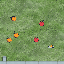

In [ ]:
display_trajectory(frames)

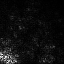

In [ ]:
display_trajectory_grad(frames_)

**Grad CAM**

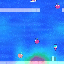

In [ ]:
import cv2

class HookFeatures():
  def __init__(self, module):
    self.feature_hook = module.register_forward_hook(self.feature_hook_fn)
  def feature_hook_fn(self, module, input, output):
    self.features = output.clone().detach()
    self.gradient_hook = output.register_hook(self.gradient_hook_fn)
  def gradient_hook_fn(self, grad):
    self.gradients = grad
  def close(self):
    self.feature_hook.remove()
    self.gradient_hook.remove()


hook = HookFeatures(agent.features)

frames = []

while True:

  obs_tensor = torch.FloatTensor(obs).to('cuda')
  output = agent(obs_tensor)
  output_idx = output.argmax()
  output_max = output[0, output_idx]
  output_max.backward()

  gradients = hook.gradients
  activations = hook.features
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # we take the average gradient of every chanels
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i] # we multiply every chanels of the feature map with their corresponding averaged gradients

  heatmap = torch.mean(activations, dim=1).squeeze()
  heatmap = np.maximum(heatmap.detach().cpu(), 0)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(np.float32(heatmap), (obs.shape[2], obs.shape[3]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW) / 255
  superposed_img = (heatmap) * 0.4 + obs_to_image(obs)/255
  superposed_img = np.clip(superposed_img,0,1)
  frames.append(superposed_img)
  action = agent(obs_tensor).argmax(1).cpu().numpy()
  obs, _, done ,_ = env.step(action)
  img = env.render()
  if done[0]:
    break

env.close()

display_trajectory_bis(frames)



**Captum**

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00


In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import DeepLift
from captum.attr import visualization as viz

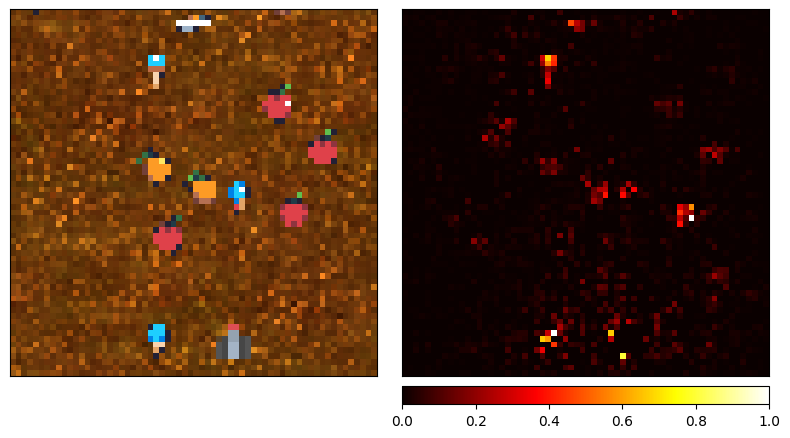

In [ ]:
def plot_heatmap(attributions, img):
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                              obs_to_image(img),
                              methods=["original_image", "heat_map"],
                              signs=['all', 'positive'],
                              cmap='hot',
                              show_colorbar=True)

# Integradted gradients (https://arxiv.org/abs/1703.01365)
integrated_gradients = IntegratedGradients(agent)
attributions = integrated_gradients.attribute(torch.FloatTensor(obs).to('cuda'), target=output_idx, n_steps=200, internal_batch_size=1)

plot_heatmap(attributions, obs)

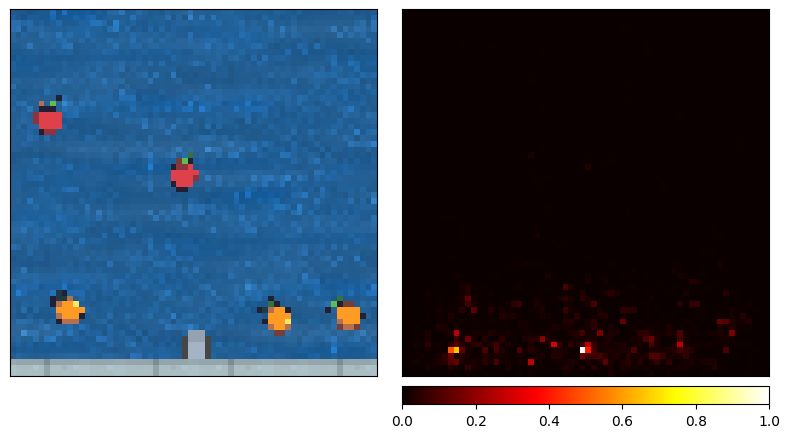

In [ ]:
#Noise tunnel (SmoothGrad, VarGrad: https://arxiv.org/abs/1810.03307)
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions = noise_tunnel.attribute(torch.FloatTensor(obs).to('cuda'), nt_samples_batch_size=1, nt_samples=10, nt_type='smoothgrad_sq', target=output_idx)

plot_heatmap(attributions, obs)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


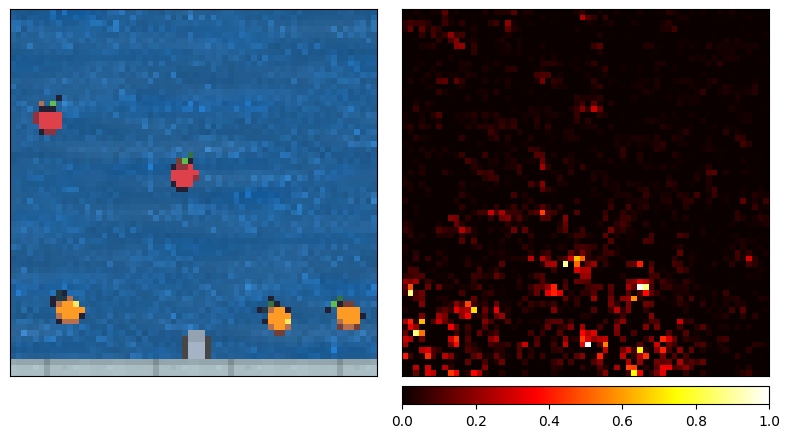

In [ ]:
#DeepLift (https://arxiv.org/pdf/1704.02685.pdf)
dl = DeepLift(agent)
attributions = dl.attribute(torch.FloatTensor(obs).to('cuda'), target=output_idx, baselines=torch.FloatTensor(obs).to('cuda') * 0)

plot_heatmap(attributions, obs)

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


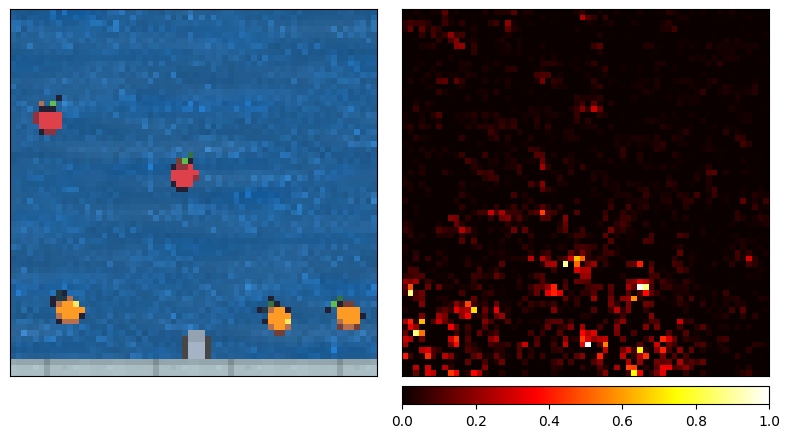

In [ ]:
#Guided Grad-CAM (https://arxiv.org/abs/1610.02391)
guided_gc = GuidedGradCam(agent, agent.features)
attribution = guided_gc.attribute(torch.FloatTensor(obs).to('cuda'), target=output_idx)
plot_heatmap(attributions, obs)